In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


file_path = '/content/drive/MyDrive/Dataset/KDDCup99.csv'
df = pd.read_csv(file_path)


print(df.info())


print(df.isnull().sum())


df = df.dropna()


df = pd.get_dummies(df)

print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  lnum_compromised             494020 non-null  int64  
 13 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Apply PCA
pca = PCA(n_components=0.95)
pca_df = pca.fit_transform(scaled_df)

# Display the shape of the dataset after PCA
print("Shape after PCA:", pca_df.shape)


In [ ]:
!pip install --upgrade pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=05d7281cf68f0672b777dc60161dcfd669399df7b36cd1f01c50d4dc210c9966
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [ ]:
!pip install git+https://github.com/annoviko/pyclustering.git

  Cloning https://github.com/annoviko/pyclustering.git to /tmp/pip-req-build-asoxired
  Running command git clone --filter=blob:none --quiet https://github.com/annoviko/pyclustering.git /tmp/pip-req-build-asoxired
  Resolved https://github.com/annoviko/pyclustering.git to commit 906532e4a5422479cc6813e852f9c3cb48ea7a64
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.11.0-py3-none-any.whl size=1068549 sha256=2886dbe0e74477471fc8debb2221752d4eb7e44666e818a0ce6aaa30d4734bbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-qyqaf5re/wheels/bd/5a/30/1060e3843b1a4912f4f5dfeb353ca6124041c774e10ddd19ba
Successfully built pyclustering
  Attempting uninstall: pyclustering
    Found existing installation: pyclustering 0.10.1.2
    Uninstalling pyclustering-0.10.1.2:
      Successfully uninstalled pyclustering-0.10.1.2


In [ ]:
import numpy as np
from pyclustering.cluster.clarans import clarans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


if pca_df.shape[0] > 49000:
    np.random.seed(42)
    sample_indices = np.random.choice(pca_df.shape[0], 49000, replace=False)
    pca_df_sampled = pca_df[sample_indices]
else:
    pca_df_sampled = pca_df

# Apply CLARANS
num_clusters = 5
num_local = 2  # Number of local minima obtained
max_neighbor = 3  # The number of neighbors to consider during search
clarans_instance = clarans(pca_df_sampled.tolist(), num_clusters, num_local, max_neighbor)
clarans_instance.process()
clarans_clusters = clarans_instance.get_clusters()

# Flatten the cluster list into a single array of labels
clarans_labels_flat = np.zeros(len(pca_df_sampled), dtype=int)
for cluster_num, cluster in enumerate(clarans_clusters):
    for index in cluster:
        clarans_labels_flat[index] = cluster_num

# Evaluate CLARANS
if len(set(clarans_labels_flat)) > 1:
    clarans_silhouette = silhouette_score(pca_df_sampled, clarans_labels_flat)
    clarans_db_score = davies_bouldin_score(pca_df_sampled, clarans_labels_flat)
    clarans_ch_score = calinski_harabasz_score(pca_df_sampled, clarans_labels_flat)

    print("CLARANS Silhouette Score:", clarans_silhouette)
    print("CLARANS Davies-Bouldin Score:", clarans_db_score)
    print("CLARANS Calinski-Harabasz Index:", clarans_ch_score)
else:
    print("CLARANS resulted in a single cluster. Scores cannot be calculated.")


CLARANS Silhouette Score: 0.37842221515763075
CLARANS Davies-Bouldin Score: 4.106286094423472
CLARANS Calinski-Harabasz Index: 2553.1328660989975


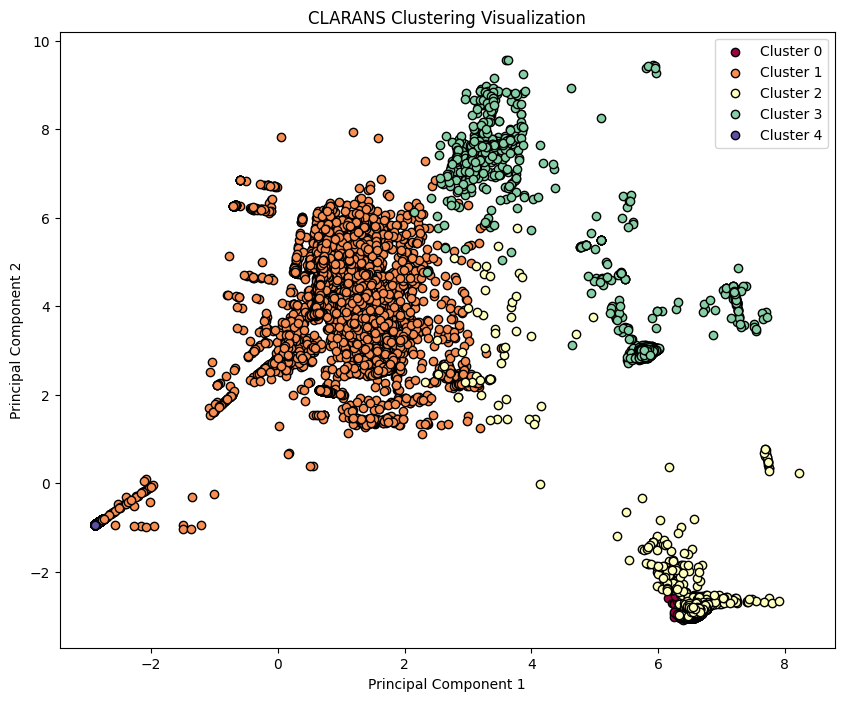

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))


unique_labels = set(clarans_labels_flat)


colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))


max_legend_clusters = 10


for k, col in zip(unique_labels, colors):
    class_member_mask = (clarans_labels_flat == k)

    xy = pca_df_sampled[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], edgecolor='k', label=f'Cluster {k}')


plt.title('CLARANS Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a custom legend with a limited number of clusters
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))


if len(by_label) > max_legend_clusters:
    legend_labels = list(by_label.keys())[:max_legend_clusters] + ['Other clusters...']
    legend_handles = list(by_label.values())[:max_legend_clusters] + [plt.Line2D([0], [0], linestyle="none")]
    plt.legend(legend_handles, legend_labels, loc='best')
else:
    plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.show()
